### colab cells only

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd "/content/drive/MyDrive/Sample Solution 2"

/content/drive/MyDrive/Sample Solution 2


# Custom Model

### create model

In [40]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

"""
The above command is an old version,
if it does not work then we can use the following command
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# OR we can also use the following command
# from keras.src.legacy.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model



### prepare data

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset
dataset_path = 'HandwrittenTextRecData/train'

# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    # validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest',
)

# Load training and validation data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(32, 32),
    batch_size=16,
    class_mode='binary',
    # subset='training',
    color_mode='grayscale',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(32, 32),
    batch_size=16,
    class_mode='binary',
    # subset='validation',
    color_mode='grayscale',
    # shuffle=True
)


Found 271 images belonging to 2 classes.
Found 271 images belonging to 2 classes.


### train model

In [ ]:
# choosing the best learning rate
model = create_model()

learning_rate_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch:0.001*(0.9**(epoch//2)))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size,
    # callbacks=[learning_rate_schedule]
)


Epoch 1/20
15/15 [==============================] - 37s 2s/step - loss: 0.5038 - accuracy: 0.8128 - val_loss: 0.3793 - val_accuracy: 0.8250
Epoch 2/20
15/15 [==============================] - 2s 164ms/step - loss: 0.3232 - accuracy: 0.8681 - val_loss: 0.2242 - val_accuracy: 0.9458
Epoch 3/20
15/15 [==============================] - 2s 139ms/step - loss: 0.1829 - accuracy: 0.9319 - val_loss: 0.3632 - val_accuracy: 0.8708
Epoch 4/20
15/15 [==============================] - 2s 133ms/step - loss: 0.2296 - accuracy: 0.9191 - val_loss: 0.2004 - val_accuracy: 0.9125
Epoch 5/20
15/15 [==============================] - 2s 153ms/step - loss: 0.1937 - accuracy: 0.9234 - val_loss: 0.1844 - val_accuracy: 0.9292
Epoch 6/20
15/15 [==============================] - 2s 129ms/step - loss: 0.1675 - accuracy: 0.9489 - val_loss: 0.1760 - val_accuracy: 0.9208
Epoch 7/20
15/15 [==============================] - 2s 131ms/step - loss: 0.1749 - accuracy: 0.9404 - val_loss: 0.1512 - val_accuracy: 0.9333
Epoch 8/

### visualizing results

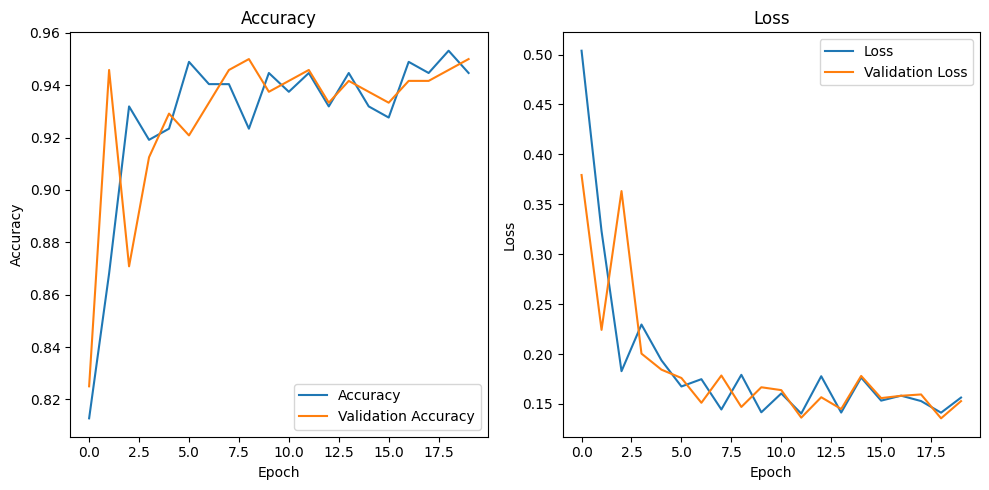

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy and loss values from the history object
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy and validation accuracy on the first subplot
ax1.plot(acc, label='Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot the loss and validation loss on the second subplot
ax2.plot(loss, label='Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()


### evaluate model

In [ ]:
model.evaluate(val_data)

16/16 [==============================] - 1s 76ms/step - loss: 0.1422 - accuracy: 0.9402


[0.14220885932445526, 0.9402390718460083]

### save model

In [ ]:
model.save('custom_modell.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Making predictions and extract text

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract
import cv2
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

ind = {0:'handwritten', 1:'printed'}
def classify_extract_text(image_path, model):
    # Load the image from the provided path
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = cv2.resize(image, (32, 32))  # Resize to match model input size
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0) / 255.0  # Add batch dimension and normalize
    # Add an extra dimension for the single channel
    image = np.expand_dims(image, axis=-1)
    prediction = model.predict(image)
    print(prediction)
    predicted_class = None
    if (prediction[0][0])>0.5:
        predicted_class=ind[1] # printed
    else:
        predicted_class=ind[0] # handwritten
    print(predicted_class)

    def enhance_image(image_path):
      # Load image
      image = cv2.imread(image_path)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      blurred = cv2.GaussianBlur(gray, (5, 5), 0)
      _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      return binary

    # Function to extract text using Tesseract
    def extract_text(image_path):
        try:
            enhanced_image = enhance_image(image_path)
            # Convert OpenCV image to PIL image for Tesseract
            pil_image = Image.fromarray(enhanced_image)
            text = pytesseract.image_to_string(pil_image)
            return text
        except Exception as e:
            print(f"Error extracting text with Tesseract: {e}")
            return ""

    extracted_text = extract_text(image_path)
    if extracted_text.__len__()!=0:
      with open('output.txt', 'w') as file:
          print("extracted_text saved to output.txt file")
          file.write(extracted_text)
          file.close()
    print(f'Extracted Text:\n{extracted_text}')
    # Show the image with predicted class
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Predicted class: {predicted_class}')
    plt.axis('off')
    plt.show()


c:\Users\PMYLS\envs\tf\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
[[0.89035016]]
printed
extracted_text saved to output.txt file
Extracted Text:
THE UNIVERSITY OF LAHORE

Faculty of Information Technology
Department of Computer Science & IT

BSCS Final Project Evaluation Report



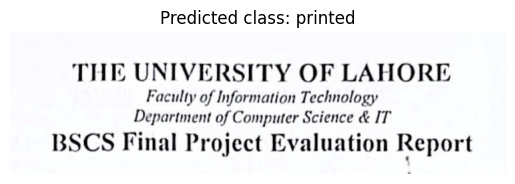

In [ ]:
modal = load_model('custom_modell.h5')
img_path = 'test1.jpg'
# Call the function with the image path
classify_extract_text(img_path, modal)

after testing few examples , we noticed that this model is making some wrong preditions

# 2. Transfer Leanring

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset
dataset_path = 'HandwrittenTextRecData/train'

# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    # validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest',
)

# Load training and validation data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(75, 75),
    batch_size=16,
    class_mode='binary',
    # subset='training',
    color_mode='rgb',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(75, 75),
    batch_size=16,
    class_mode='binary',
    # subset='validation',
    color_mode='rgb',
    shuffle=True
)


Found 251 images belonging to 2 classes.
Found 251 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

def create_tl_model():
    base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
    base_model.trainable = False
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model



tl_model = create_tl_model()
tl_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

tl_model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20


c:\Users\PMYLS\envs\ai\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.7298 - loss: 0.5860 - val_accuracy: 0.9602 - val_loss: 0.1012
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9682 - loss: 0.1127 - val_accuracy: 0.9602 - val_loss: 0.0835
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9440 - loss: 0.0968 - val_accuracy: 0.9602 - val_loss: 0.0817
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.9941 - loss: 0.0433 - val_accuracy: 0.9721 - val_loss: 0.0636
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9576 - loss: 0.0973 - val_accuracy: 0.9721 - val_loss: 0.0661
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - accuracy: 0.9831 - loss: 0.0613 - val_accuracy: 0.9602 - val_loss: 0.0617
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9561 - loss: 0.1075 - val_accuracy: 0.9920 - val_loss: 0.0418
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9920 - loss: 0.0326 - val_accuracy: 0.9880 - val

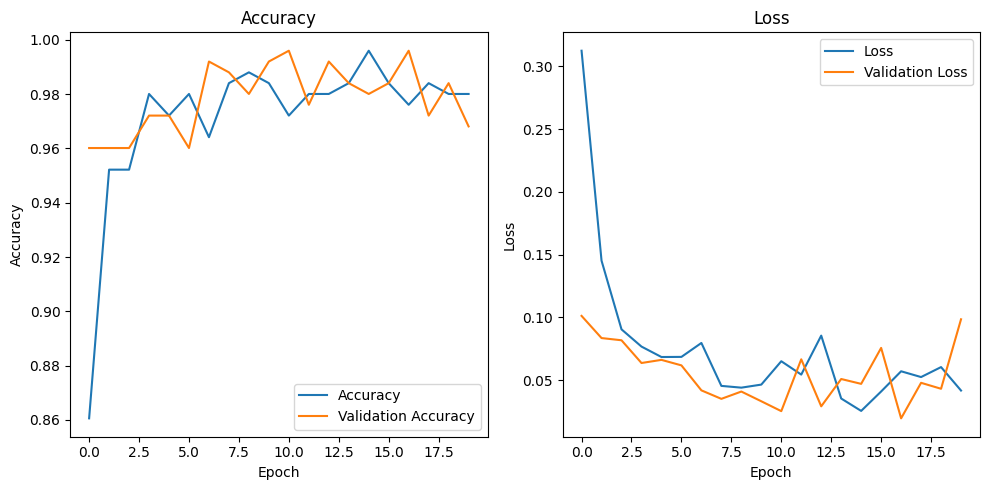

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy and loss values from the history object
acc = tl_model.history.history['accuracy']
loss = tl_model.history.history['loss']
val_acc = tl_model.history.history['val_accuracy']
val_loss = tl_model.history.history['val_loss']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy and validation accuracy on the first subplot
ax1.plot(acc, label='Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot the loss and validation loss on the second subplot
ax2.plot(loss, label='Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
tl_model.evaluate(val_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9840 - loss: 0.0834


[0.08146689087152481, 0.9840637445449829]

In [ ]:
# tl_model.save('tl_model.h5')  ## uncomment and run only if you want to save the new model

In [ ]:
import cv2
from keras.preprocessing.image import img_to_array
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract
import cv2
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

ind = {0:'handwritten', 1:'printed'}
def classify_extract_text(image_path, model):
    # Load the image from the provided path
    image = cv2.imread(image_path)

    # Check if image loaded successfully
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    # Resize to match model input size before converting to grayscale if needed
    image = cv2.resize(image, (75, 75))

    image = img_to_array(image)
    image = np.expand_dims(image, axis=0) / 255.0  # Add batch dimension and normalize
    prediction = model.predict(image)
    print(prediction)
    predicted_class = None
    if prediction[0][0]>0.5:
        predicted_class=ind[1] # printed
    else:
        predicted_class=ind[0] # hadwritten
    print(predicted_class)

    def enhance_image(image_path):
      # Load image
      image = cv2.imread(image_path)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      blurred = cv2.GaussianBlur(gray, (5, 5), 0)
      _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      return binary

    # Function to extract text using Tesseract
    def extract_text(image_path):
        try:
            enhanced_image = enhance_image(image_path)
            # Convert OpenCV image to PIL image for Tesseract
            pil_image = Image.fromarray(enhanced_image)
            text = pytesseract.image_to_string(pil_image)
            return text
        except Exception as e:
            print(f"Error extracting text with Tesseract: {e}")
            return ""

    extracted_text = extract_text(image_path)
    if extracted_text.__len__()!=0:
      with open('output.txt', 'w') as file:
          print("extracted_text saved to output.txt file")
          file.write(extracted_text)
          file.close()
    print(f'Extracted Text:\n{extracted_text}')
    # Show the image with predicted class
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Predicted class: {predicted_class}')
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.98132396]]
printed
extracted_text saved to output.txt file
Extracted Text:
Sentence Database A01-003

Though they may gather some Left-wing support, a large majority of Labour 0M Ps
are likely to turn down the Foot-Griffiths resolution. Mr. Foot’s line will be that as
Labour 0M Ps opposed the Government Bill which brought life peers into existence,
they should not now put forward nominees. He believes that the House of Lords
should be abolished and that Labour should not take any steps which would appear
to *prop up” an out-dated institution.



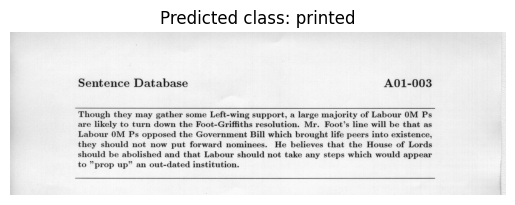

In [ ]:
from keras.models import load_model
modal = load_model('tl_model.h5')
img_path = 'Sample-1.png'
# Call the function with the image path
classify_extract_text(img_path, model=modal)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.00557359]]
handwritten
extracted_text saved to output.txt file
Extracted Text:
Thug Hay may salker Some wing soypat a
lage nasty of Kabour OM B ave Lbely Yo bum
det the Foot. Gifts rsolakon Mr root's kine
nH be that as labour OM & B epperot tke Gover
mut 1 hich Lreyl f bh fees (utd en'sheace, Hay
should mot nocd put Jeseere morn uces . We bebrve,
laf ls Mouse of Leds shoul be aBolshed aol
Hat Lebour shoul 10 Kaley Quy shys Uo ised



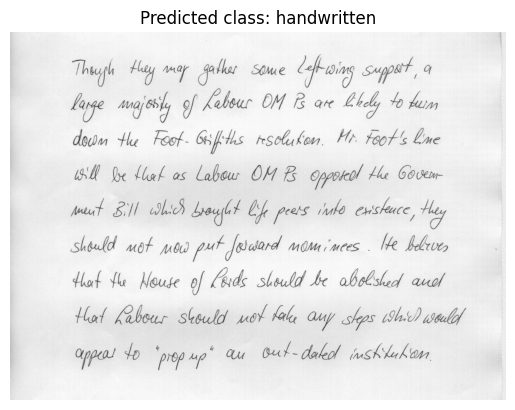

In [ ]:
modal = load_model('tl_model.h5')
img_path = 'Sample-11.png'
# Call the function with the image path
classify_extract_text(img_path, modal)

# 3. Transformers
- if you want to again train model, please use google colab with GPU backend. otherwise it will take a lot of time for training.

In [ ]:
# !pip install datasets transformers

import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from datasets import load_metric
import numpy as np

# Preprocess images function
def preprocess_images(examples):
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
    # Ensure images are in RGB format and have the channel dimension last
    images = [np.array(image.convert("RGB")) for image in examples['image']]
    images = [feature_extractor(images=image, return_tensors='pt')["pixel_values"].squeeze() for image in images]
    examples['pixel_values'] = images
    examples.pop('image', None)
    return examples

dataset_path = 'HandwrittenTextRecData/train'
dataset = load_dataset('imagefolder', data_dir=dataset_path)
dataset = dataset.map(preprocess_images, batched=True)
dataset = dataset.rename_column("label", "labels")

# Split the dataset
split = dataset['train'].train_test_split(test_size=0.2)
dataset = DatasetDict({
    'train': split['train'],
    'validation': split['test']
})

Resolving data files:   0%|          | 0/271 [00:00<?, ?it/s]

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 216
    })
    validation: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 55
    })
})

In [ ]:
# Load the model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)

# Define metric
metric = load_metric('accuracy')

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-1753c539ef62>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    save_steps=10_000,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=10,
)

# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy
1,0.426400,0.203848,0.981818
2,0.209100,0.083029,1.000000
3,0.053500,0.049381,1.000000
4,0.049700,0.039925,1.000000
5,0.033300,0.036842,1.000000


TrainOutput(global_step=70, training_loss=0.12860631559576308, metrics={'train_runtime': 181.7168, 'train_samples_per_second': 5.943, 'train_steps_per_second': 0.385, 'total_flos': 8.369134878375936e+16, 'train_loss': 0.12860631559576308, 'epoch': 5.0})

### Ploting resutls

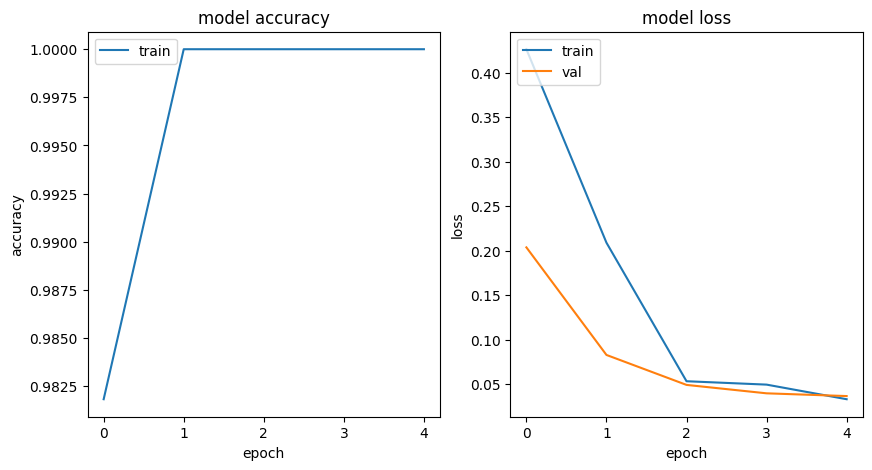

In [ ]:
import matplotlib.pyplot as plt
# Epoch,	Training Loss,	Validation Loss,	Accuracy
# 1	0.426400	0.203848	0.981818
# 2	0.209100	0.083029	1.000000
# 3	0.053500	0.049381	1.000000
# 4	0.049700	0.039925	1.000000
# 5	0.033300	0.036842	1.000000

acc = [0.981818,1.000000,1.000000,1.000000,1.000000]
train_loss = [0.426400,0.209100,0.053500,0.049700,0.033300]
val_loss = [0.203848,0.083029,0.049381,0.039925,0.036842]

# accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')

#loss
plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.2f}")

# Save the model
trainer.save_model("vit-handwritten-printed")

Validation Accuracy: 1.00


## Make Predictions using single image

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from PIL import Image

# Load the trained model
model = ViTForImageClassification.from_pretrained('./vit-handwritten-printed')

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs['pixel_values']

# Function to make predictions
def predict(image_path):
    model.eval()
    pixel_values = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(pixel_values)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Predicted class: handwritten


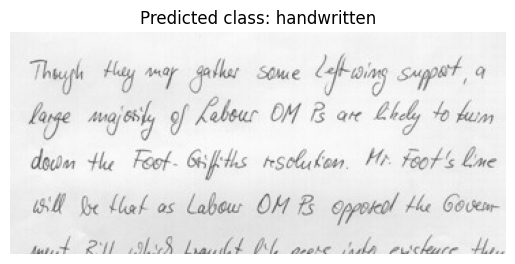

Predicted class: printed


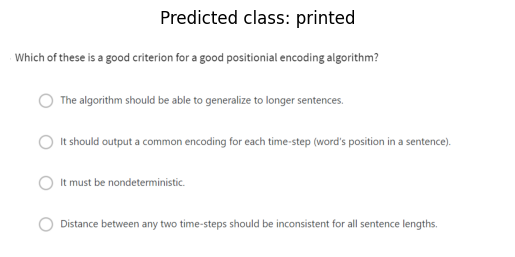

Predicted class: printed


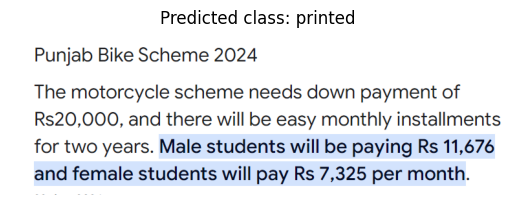

Predicted class: printed


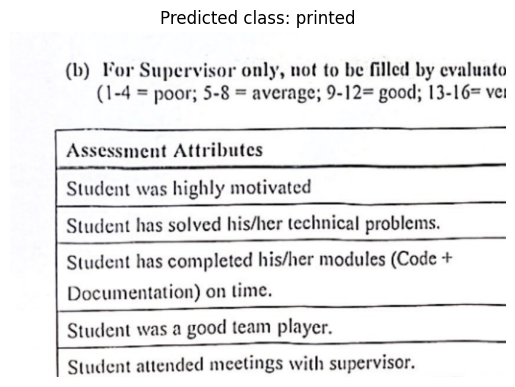

Predicted class: handwritten


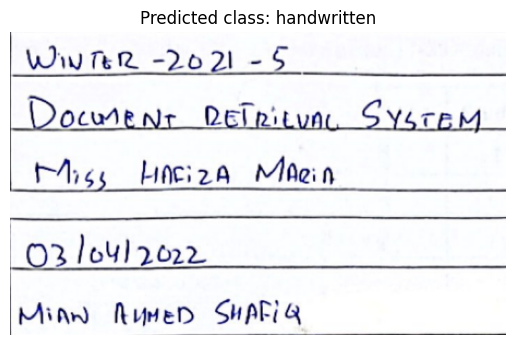

Predicted class: printed


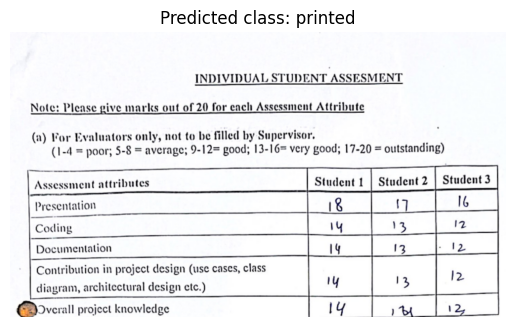

Predicted class: handwritten


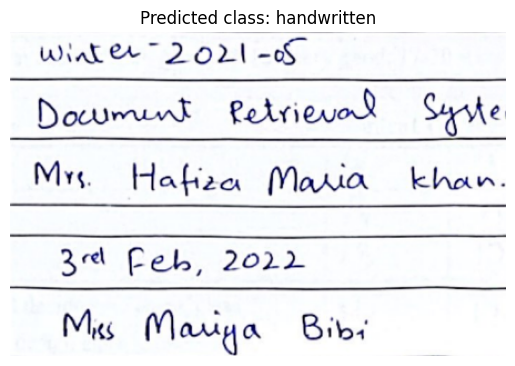

Predicted class: handwritten


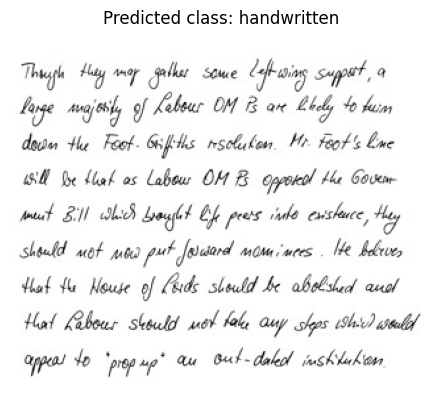

In [ ]:
import matplotlib.pyplot as plt

## Example usage
image_path = 'test1.jpg'
class_labels = {0: 'handwritten', 1: 'printed'}
img_paths = ["1.jpg", "2.png", "3.png", "4.png", "5.png", "6.png", "7.png", "8.jpg"]
for img_path in img_paths:
# Call the function with the image path
    predicted_class_idx = predict("/content/"+img_path)
    predicted_class = class_labels[predicted_class_idx]
    print(f'Predicted class: {predicted_class}')

    # Show the image with predicted class
    image = Image.open("/content/"+img_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Predicted class: {predicted_class}')
    plt.axis('off')
    plt.show()



Predicted class: handwritten


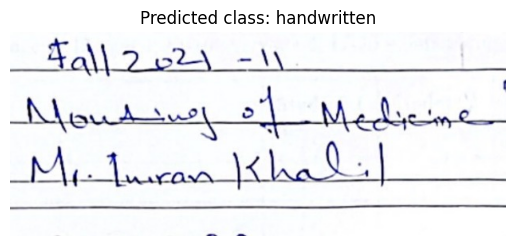

In [16]:
## Example usage
image_path = 'test2.jpg'
class_labels = {0: 'handwritten', 1: 'printed'}

predicted_class_idx = predict(image_path)
predicted_class = class_labels[predicted_class_idx]
print(f'Predicted class: {predicted_class}')

# Show the image with predicted class
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')
plt.show()

### Make Predictions and Extract text

In [19]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from PIL import Image
import matplotlib.pyplot as plt
# import pytesseract
import cv2
import numpy as np

# Path to the Tesseract executable
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Update this to your Tesseract installation path

# Verify Tesseract installation
# print(f"Tesseract executable: {pytesseract.pytesseract.tesseract_cmd}")
# try:
#     tess_version = pytesseract.get_tesseract_version()
#     print(f"Tesseract version: {tess_version}")
# except Exception as e:
#     print(f"Error verifying Tesseract installation: {e}")

# Load the trained model
model = ViTForImageClassification.from_pretrained('./vit-handwritten-printed')

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Function to preprocess the image for classification
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs['pixel_values']

# Function to make predictions
def predict(image_path):
    model.eval()
    pixel_values = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(pixel_values)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx

# Function to enhance image quality
def enhance_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# Function to extract text using Tesseract
def extract_text(image_path):
    try:
        enhanced_image = enhance_image(image_path)
        # Convert OpenCV image to PIL image for Tesseract
        pil_image = Image.fromarray(enhanced_image)
        text = pytesseract.image_to_string(pil_image)
        return text
    except Exception as e:
        print(f"Error extracting text with Tesseract: {e}")
        return ""


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Predicted class: printed
Error extracting text with Tesseract: name 'pytesseract' is not defined
Extracted Text:



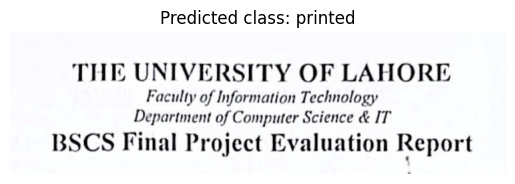

In [20]:
image_path = 'test1.jpg'
class_labels = {0: 'handwritten', 1: 'printed'}

predicted_class_idx = predict(image_path)
predicted_class = class_labels[predicted_class_idx]
print(f'Predicted class: {predicted_class}')

# Extract text using Tesseract
extracted_text = extract_text(image_path)
print(f'Extracted Text:\n{extracted_text}')

if extracted_text.__len__()!=0:
    with open('output.txt', 'w') as file:
        print("extracted_text saved to output.txt file")
        file.write(extracted_text)
        file.close()

# Show the image with predicted class
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')
plt.show()